# SAFIR Workflow Demonstration Notebook

This notebook demonstrates a sample use case to process input data from healthcare and environmental readings of a user. The workflow includes:

1. **Achieving Semantic Data Interoperability**: Transforming JSON input data into RDF, making it machine-readable and semantically enriched.
2. **Graph Learning and Visualization**: Constructing and analyzing the RDF graph, with metrics calculation for insights.
3. **Metrics Calculation**: Evaluating the performance and utility of the generated RDF graph through visualizations and metrics.

Uncomment the following line if you haven't installed the necessary dependencies yet.

In [ ]:
# Install the required packages
# !pip install -r requirements.txt

Dependencies may include libraries for RDF processing, machine learning, and graph visualization.

In [11]:
# Importing required libraries
import requests  # For making HTTP requests to external APIs
import rdflib  # For working with RDF data and generating RDF graphs
import networkx as nx  # For graph-based learning and visualization
import matplotlib.pyplot as plt  # For creating visualizations such as plots and graphs
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations and handling arrays
from sklearn.metrics import classification_report, roc_auc_score  # For evaluating model performance
import os  # For interacting with the file system

In [2]:
# Constants and Configuration

# The base URL for the API that generates RDF data
API_URL = "http://api:8080/api/v1/rdf/gi/generate-rdf"

# File paths for storing the RDF output and the generated graph
RDF_OUTPUT_FILE = "output.ttl"
GRAPH_OUTPUT_FILE = "graph.gpickle"

These paths are used to save the results of the RDF transformation and graph learning process.

The JSON contains sample data for various devices, sensors, actuators, and events.

This data represents interactions between these entities and will be processed to generate RDF.

In [12]:
# Define the JSON input
json_input = {
    "dataModel": "source_a",  # Data model identifier
    "jsonData": {
        "devices": [
            {
                "id": "dev_001",  # Device identifier
                "name": "Primary Device",  # Device name
                "serialNumber": "SN123456",  # Serial number of the device
                "owner": "usr_001"  # Owner identifier of the device
            }
        ],
        "actuators": [
            {
                "id": "act_001",  # Actuator identifier
                "deviceId": "dev_001"  # Associated device identifier
            }
        ],
        "uiDevices": [
            {
                "id": "ui_001",  # UI Device identifier
                "sensorId": "sens_001",  # Associated sensor identifier
                "actuatorId": "act_001",  # Associated actuator identifier
                "deviceId": "dev_001"  # Associated device identifier
            }
        ],
        "sensors": [
            {
                "id": "sens_001",  # Sensor identifier
                "type": "TEMPERATURE",  # Sensor type
                "location": "Living Room",  # Sensor location
                "threshold": 35.0,  # Threshold for sensor values
                "deviceId": "dev_001"  # Associated device identifier
            }
        ],
        "events": [
            {
                "timestamp": "2021-09-29T11:19:11.788Z",  # Event timestamp
                "id": "evt_001",  # Event identifier
                "userId": "usr_002",  # User associated with the event
                "assetId": "asset_001",  # Associated asset
                "dimension": "VALUE",  # Event dimension (e.g., temperature)
                "value": 28.7,  # Event value (e.g., sensor reading)
                "originId": "sens_001",  # Originating sensor
                "originType": "TEMPERATURE"  # Type of originating sensor
            },
            {
                "timestamp": "2024-06-01T00:00:00.000Z",  # Event timestamp
                "id": "evt_002",  # Event identifier
                "userId": "usr_003",  # User associated with the event
                "assetId": "asset_002",  # Associated asset
                "dimension": "VALUE",  # Event dimension (e.g., humidity)
                "value": 38.24,  # Event value (e.g., sensor reading)
                "originId": "sens_002",  # Originating sensor
                "originType": "HUMIDITY"  # Type of originating sensor
            }
        ]
    }
}

In [4]:
# Call the external API for RDF generation
def generate_rdf(json_data):
    """
    Send JSON input to the external RML API and receive RDF in turtle format.
    """
    response = requests.post(API_URL, json=json_data)
    if response.status_code == 200:
        # Save RDF to file
        with open(RDF_OUTPUT_FILE, "w") as rdf_file:
            rdf_file.write(response.text)
        print("RDF generation successful. Saved to:", RDF_OUTPUT_FILE)
    else:
        print("RDF generation failed with status code:", response.status_code)
        response.raise_for_status()

generate_rdf(json_input)

RDF generation successful. Saved to: output.ttl


In [5]:
# Convert RDF to NetworkX graph
def rdf_to_graph(rdf_graph):
    """
    Convert RDF triples to a NetworkX graph.
    """
    nx_graph = nx.DiGraph()
    for subj, pred, obj in rdf_graph:
        nx_graph.add_edge(str(subj), str(obj), predicate=str(pred))
    print("Converted RDF to NetworkX graph with", len(nx_graph.nodes), "nodes and", len(nx_graph.edges), "edges.")
    return nx_graph


In [6]:
with open(RDF_OUTPUT_FILE, "r") as rdf_file:
    rdf_content = rdf_file.read()
    print(rdf_content)

@prefix dcat: <http://www.w3.org/ns/dcat#> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix fhir: <http://hl7.org/fhir/> .
@prefix hultig: <http://hultig.ubi.pt/ontology/source_a#> .
@prefix prov: <http://www.w3.org/ns/prov#> .
@prefix ql: <http://semweb.mmlab.be/ns/ql#> .
@prefix rml: <http://semweb.mmlab.be/ns/rml#> .
@prefix rr: <http://www.w3.org/ns/r2rml#> .
@prefix schema: <http://schema.org/> .
@prefix sosa: <http://www.w3.org/ns/sosa/> .
@prefix ucum: <http://unitsofmeasure.org/> .
@prefix void: <http://rdfs.org/ns/void#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<http://hultig.ubi.pt/ontology/source_a/actuator/act_001> a sosa:Actuator;
  sosa:isHostedBy <http://hultig.ubi.pt/ontology/source_a/device/dev_001> .

<http://hultig.ubi.pt/ontology/source_a/platform/ui_001> a sosa:Platform;
  sosa:hosts <http://hultig.ubi.pt/ontology/source_a/actuator/act_001>, <http://hultig.ubi.pt/ontology/source_a/sensor/sens_001>;
  sosa:isHostedBy <http://hultig.ubi.pt/ontolo

In [7]:
import rdflib
import networkx as nx
import pickle

# Parse RDF file
rdf_graph = rdflib.Graph()
rdf_graph.parse(RDF_OUTPUT_FILE, format="turtle")

# Convert RDF to NetworkX graph
nx_graph = rdf_to_graph(rdf_graph)

# Write NetworkX graph to pickle file
with open(GRAPH_OUTPUT_FILE, 'wb') as f:
    pickle.dump(nx_graph, f, pickle.HIGHEST_PROTOCOL)

print(f"Converted RDF to NetworkX graph and saved to {GRAPH_OUTPUT_FILE}.")


Converted RDF to NetworkX graph with 21 nodes and 22 edges.
Converted RDF to NetworkX graph and saved to graph.gpickle.


In [8]:
# =======================================
# Step 3: Graph Learning
# =======================================

# Perform Node Classification
def simulate_node_classification(graph):
    """
    Simulate node classification using random labels and calculate metrics.
    """
    # Assign random labels (simulating predictions)
    for node in graph.nodes:
        graph.nodes[node]['label'] = np.random.choice(['low_risk', 'medium_risk', 'high_risk'])
        graph.nodes[node]['true_label'] = np.random.choice(['low_risk', 'medium_risk', 'high_risk'])

    # Extract labels
    y_true = [graph.nodes[node]['true_label'] for node in graph.nodes]
    y_pred = [graph.nodes[node]['label'] for node in graph.nodes]

    # Calculate classification metrics
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['low_risk', 'medium_risk', 'high_risk']))

simulate_node_classification(nx_graph)



Classification Report:
              precision    recall  f1-score   support

    low_risk       0.38      0.43      0.40         7
 medium_risk       0.17      0.14      0.15         7
   high_risk       0.43      0.43      0.43         7

    accuracy                           0.33        21
   macro avg       0.32      0.33      0.33        21
weighted avg       0.32      0.33      0.33        21



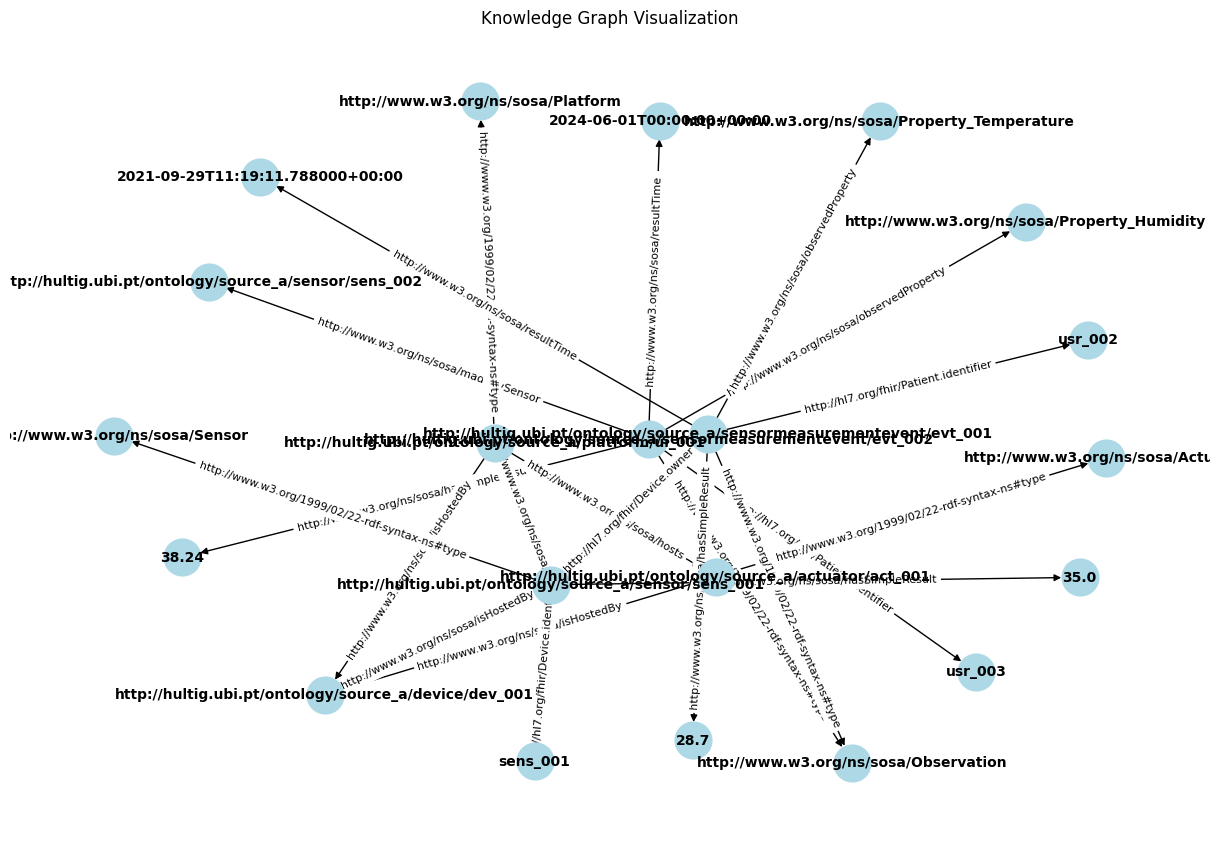

In [9]:
# =======================================
# Step 4: Visualization
# =======================================

# Visualize the graph
def visualize_graph(graph):
    """
    Visualize the graph using NetworkX.
    """
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_size=700, node_color="lightblue", font_size=10, font_weight="bold")
    edge_labels = nx.get_edge_attributes(graph, "predicate")
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)
    plt.title("Knowledge Graph Visualization")
    plt.show()

visualize_graph(nx_graph)

In [10]:
# =======================================
# Step 5: Metrics Calculation
# =======================================

def calculate_metrics(graph):
    """
    Calculate and display key metrics for the workflow.
    """
    # Graph structure metrics
    num_nodes = len(graph.nodes)
    num_edges = len(graph.edges)
    avg_degree = sum(dict(graph.degree).values()) / num_nodes

    # Report metrics
    print("\n--- Metrics ---")
    print(f"Number of Nodes: {num_nodes}")
    print(f"Number of Edges: {num_edges}")
    print(f"Average Node Degree: {avg_degree:.2f}")

calculate_metrics(nx_graph)


--- Metrics ---
Number of Nodes: 21
Number of Edges: 22
Average Node Degree: 2.10
